<a href="https://colab.research.google.com/github/maicg01/python-image-processing/blob/main/train_face_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 708 kB 14.4 MB/s 
     |████████████████████████████████| 529 kB 62.5 MB/s 


In [14]:
import zipfile
from PIL import Image
import torch
import torchvision
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torchvision.models as models
from torchvision import transforms as T
import torch
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import random
from sklearn.model_selection import train_test_split

In [4]:
def prepare_data():
    train_zip = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/CP/data.zip')
    file_names = [fname for fname in train_zip.namelist() if 'good/f' in fname or 'bad/f' in fname]
    print('Loading images metadata...')
    images = [Image.open(train_zip.open(fname)).resize((32,32)) for fname in file_names]
    print('Reading pixels...')
    for i, img in enumerate(images):
        img.load()
        if i % 100 == 0:
            print(i)
    [img.load() for img in images]
    print('Done', len(images))
    targets = [1 if 'good' in fname else 0 for fname in file_names]

    return images, targets

class MyDataset(Dataset):
  def __init__(self, images, targets, transform=None):
    super().__init__()
    self.images = images
    self.targets = targets
    self.transform = transform

  def __len__(self):
    return len(self.targets)

  def __getitem__(self, idx):
    img = self.images[idx]
    y = self.targets[idx]
    if self.transform is not None:
      img = self.transform(img)
    
    return img, y



In [5]:
images, targets = prepare_data()

Loading images metadata...
Reading pixels...
0
100
200
300
400
500
600
700
Done 793


In [7]:
train_transform = T.Compose([T.ToTensor(),
       T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [10]:
train_images, test_images, train_targets, test_targets = train_test_split(images, targets, test_size=0.1, shuffle=True)
train = MyDataset(train_images, train_targets, transform=train_transform)
test = MyDataset(test_images, test_targets, transform=train_transform)

In [11]:
print(train)

In [13]:
trainloader = DataLoader(train, batch_size=4)
testloader = DataLoader(test, batch_size=4)


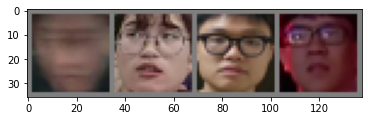

bad   good  good  good 


In [16]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
batch_size = 4
classes = ('bad', 'good')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [17]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [18]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [19]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


In [20]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

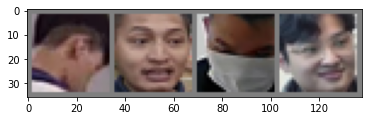

GroundTruth:  bad   good  bad   good 


In [21]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [22]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [23]:
outputs = net(images)

In [24]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  bad   good  bad   good 


In [26]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 92 %
